<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics" data-toc-modified-id="Basics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics</a></span></li><li><span><a href="#Load-Example-Data" data-toc-modified-id="Load-Example-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Example Data</a></span><ul class="toc-item"><li><span><a href="#Target-Series" data-toc-modified-id="Target-Series-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Target Series</a></span></li></ul></li><li><span><a href="#Basic-Methods" data-toc-modified-id="Basic-Methods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic Methods</a></span><ul class="toc-item"><li><span><a href="#Denton" data-toc-modified-id="Denton-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Denton</a></span></li><li><span><a href="#Denton-Cholette" data-toc-modified-id="Denton-Cholette-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Denton-Cholette</a></span></li><li><span><a href="#Using-Indicator-Variables" data-toc-modified-id="Using-Indicator-Variables-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Using Indicator Variables</a></span></li></ul></li><li><span><a href="#Regression-Based-Methods" data-toc-modified-id="Regression-Based-Methods-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regression-Based Methods</a></span><ul class="toc-item"><li><span><a href="#Chow-Lin" data-toc-modified-id="Chow-Lin-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Chow-Lin</a></span></li><li><span><a href="#Litterman" data-toc-modified-id="Litterman-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Litterman</a></span></li></ul></li><li><span><a href="#Yearly-to-Monthly" data-toc-modified-id="Yearly-to-Monthly-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Yearly to Monthly</a></span></li></ul></div>

In [1]:
from ts_disagg import disaggregate_series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plot_defaults = {
    "figure.figsize": (14, 4),
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(plot_defaults)

# Basics 

The `tsdisagg` package allows time series to be "disaggregated" into lower time frequencies. Currently, disaggregation from Annual to Monthy, Annual to Quarterly, and Quarterly to Monthly are supported.

Several options exist for aggregation and interpolation of the missing data. Time series can be disaggregated such that the new series is re-aggregated via summation, averaging, or by taking the first or last value. Summation is useful for flow variables, while taking the first or last is appropriate for stock variables. Averaging is useful for rates.

In the basic case, the low-frequency time series is simply interpolated in a way that respects the requested aggregation constraint. Using high-frequency indicator series is also supported. In this case, it is a assumed that the missing data is correlated with the indicator series. Supported methods are `denton`, `denton-cholette`, `chow-lin` and `litterman`. The first two are non-parameteric approaches, which `denton-chalotte` being a strict improvement over `denton`. `chow-lin` and `litterman` use maximum-likelihood GLS estimation to find a good interpolation for the low-frequency data using the high-frequency indicator.

Implementation is based on the R package `tempdisagg`, and especially the accompanying paper:

https://journal.r-project.org/archive/2013-2/sax-steiner.pdf

# Load Example Data

Example data is taken from the R package `tempdisagg`

In [2]:
sales_a = pd.read_csv("tests/data/sales_a.csv", index_col=0)
sales_a.index = pd.date_range(start="1975-01-01", freq="YS", periods=sales_a.shape[0])
sales_a.columns = ["sales"]

exports_q = pd.read_csv("tests/data/exports_q.csv", index_col=0)
exports_q.index = pd.date_range(start="1972-01-01", freq="QS", periods=exports_q.shape[0])
exports_q.columns = ["exports"]

exports_m = pd.read_csv("tests/data/exports_m.csv", index_col=0)
exports_m.index = pd.date_range(start="1972-01-01", freq="MS", periods=exports_m.shape[0])
exports_m.columns = ["exports"]

imports_q = pd.read_csv("tests/data/imports_q.csv", index_col=0)
imports_q.index = pd.date_range(start="1972-01-01", freq="QS-OCT", periods=imports_q.shape[0])
imports_q.columns = ["imports"]

## Target Series

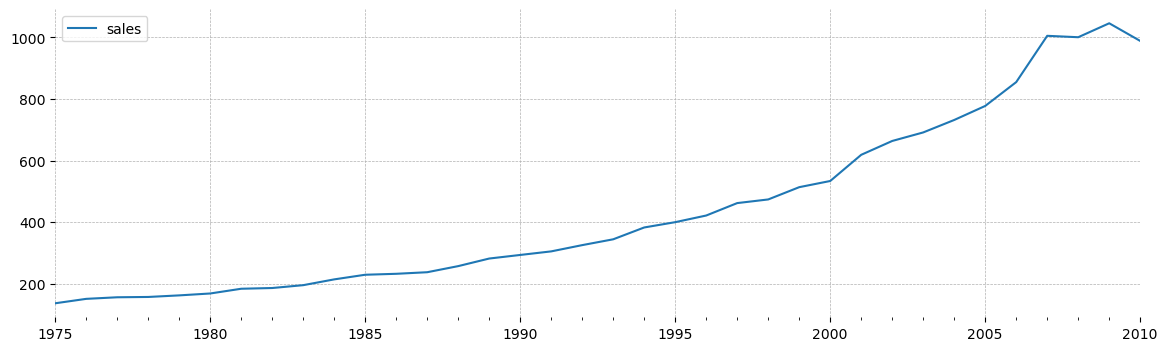

In [3]:
sales_a.plot();

# Basic Methods

To specify the desired output frequency, pass a valid Pandas frequency string to the `target_freq` parameter.

## Denton

The simplest method is `denton`, which naively interpolates by simply respecting the `agg_func`. Since sales are a flow variable, we ask for the the disaggregated series to sum back to the original series.

In [4]:
sales_q_denton = disaggregate_series(
    sales_a.resample("YS").last(), target_freq="QS", method="denton", agg_func="sum"
)

<Axes: >

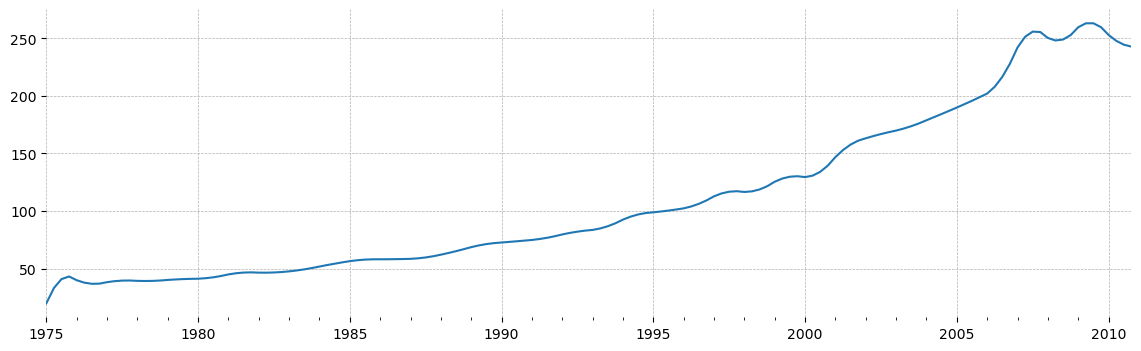

In [5]:
sales_q_denton.plot()

In [6]:
np.allclose(sales_q_denton.resample("YS").sum().values.ravel(), sales_a.values.ravel())

True

## Denton-Cholette

Notice that the first few values of the series produced by `denton` are very slow and highly variable. `denton-chalotte` applies a simple differencing-based correction to fix this. The number of differences used in the correction is controlled by the parameter `h`. 

In [7]:
sales_q_dc = disaggregate_series(
    sales_a.resample("YS").last(),
    target_freq="QS",
    method="denton-cholette",
    agg_func="sum",
    h=1,
)

The resulting series is smoother towards the beginning, but otherwise identical.

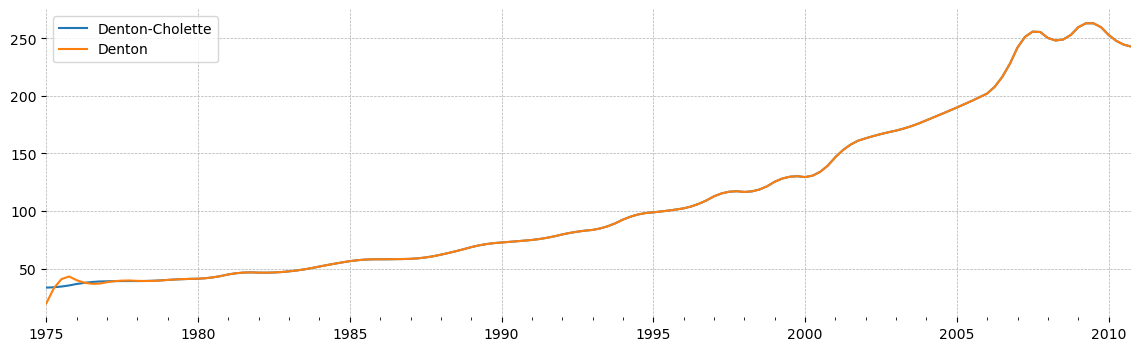

In [8]:
fig, ax = plt.subplots()
sales_q_dc.plot(ax=ax, label="Denton-Cholette")
sales_q_denton.plot(ax=ax, label="Denton")
ax.legend()
plt.show()

## Using Indicator Variables

`Denton` and `Denton-Cholette` can be used without an indicator matrix. This is equilvalent to passing a vector of 1s as the indicator matrix. Alternatively, an indicator variable can be used. For these two methods, only a single indicator can be used. If an indicator matrix is provided, the intercept vector is omitted.

When an indicator is provided, it is not necessary to specify the `target_freq`. It will be inferred automatically from the indicator matrix.

In [9]:
sales_q_dc_indicator = disaggregate_series(
    sales_a, exports_q, method="denton-cholette", agg_func="sum", h=1
)

The resulting series respects the addition constraint, and also inherits variation from the indicator series. Notice also that there was additional data from before 1975 in the indicator matrix. The "missing values" in the low-frequency data will be filled using this additional data.

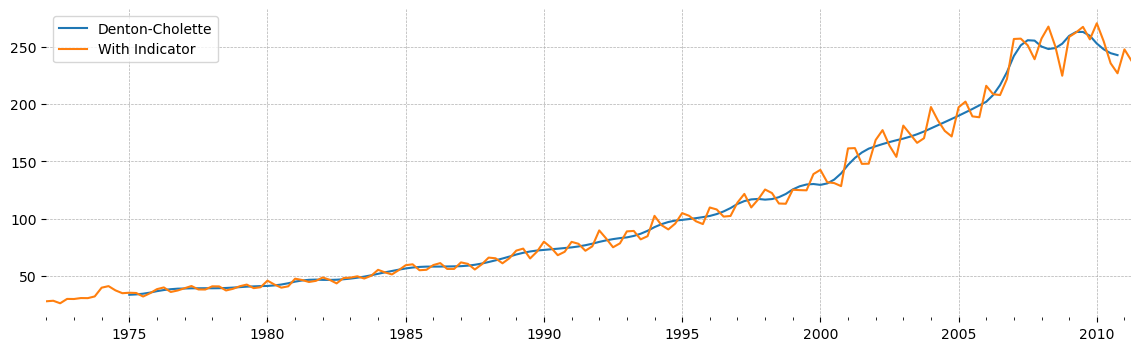

In [10]:
fig, ax = plt.subplots()
sales_q_dc.plot(ax=ax, label="Denton-Cholette")
sales_q_dc_indicator.plot(ax=ax, label="With Indicator")
ax.legend()
plt.show()

# Regression-Based Methods

`denton` and `denton-cholette` are essentially heuristic methods. To get more accurate interpolations, regression-based methods can be used. Two options are provided: `chow-lin` and `litterman`. Both are maximum likelihood estimation of GLS, and vary only in the method of computing the covariance matrix used in GLS. For more details, see the paper linked above.

Maximum likelihood is implemented using the `scipy.optim.minimize` function. Arguments to this function, such as the optimization algorithm, can be passed into the `optimizer_kwargs` argument. Two boundary conditions are used in the minimization, one to restrict the variance term positive, and one to restrict an AR(1) coefficient used in the covariance matrix to be between 0 and 1. As a result, you should only use optimizer algorithms that can respect these boundaries.

By default, the Nelder-Mead algorithm is used.

## Chow-Lin

Unlike the Denton methods, `chow-lin` and `litterman` can take as many indicators as you like. Here, we add an intercept term to the exports indicator.

In [11]:
sales_q_chow_lin = disaggregate_series(
    sales_a,
    exports_q.assign(intercept=1),
    method="chow-lin",
    agg_func="sum",
    optimizer_kwargs={"method": "powell"},
)

Dependent Variable: yearly_sales
GLS Estimates using Chow-Lin's covariance matrix
N = 158		df = 154
Adj r2 = 0.9948

Variable             coef         sd err              t        P > |t|         [0.025         0.975]
----------------------------------------------------------------------------------------------------
exports            0.0134         0.0001        91.0936         0.0000         0.0131         0.0137
intercept         12.4089         1.2963         9.5724         0.0000         9.8480        14.9697

rho                0.0000
sigma.sq          98.8717


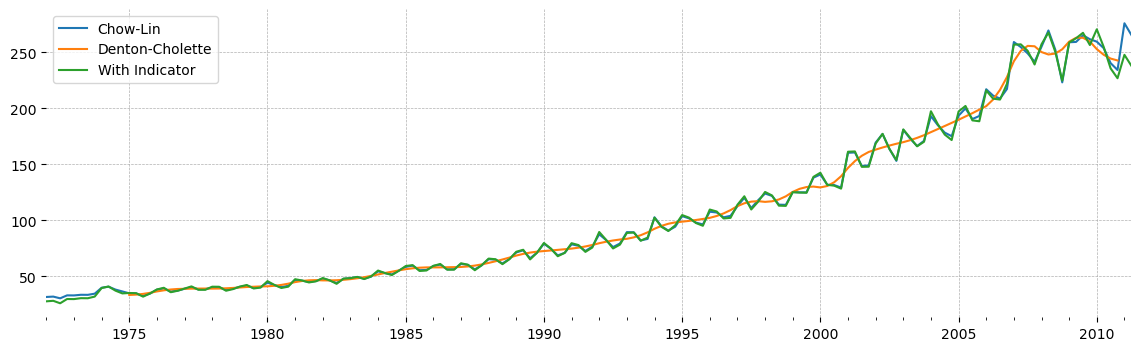

In [12]:
fig, ax = plt.subplots()
sales_q_chow_lin.plot(ax=ax, label="Chow-Lin")
sales_q_dc.plot(ax=ax, label="Denton-Cholette")
sales_q_dc_indicator.plot(ax=ax, label="With Indicator")
ax.legend()
plt.show()

## Litterman

Here we use 3 indicators: imports, exports, and an intercept.

In [13]:
sales_q_litterman = disaggregate_series(
    sales_a,
    exports_q.join(imports_q).assign(intercept=1),
    method="litterman",
    agg_func="sum",
    optimizer_kwargs={"method": "l-bfgs-b"},
)

Dependent Variable: yearly_sales
GLS Estimates using Litterman's covariance matrix
N = 158		df = 153
Adj r2 = 0.9076

Variable             coef         sd err              t        P > |t|         [0.025         0.975]
----------------------------------------------------------------------------------------------------
exports            0.0057         0.0006        10.3003         0.0000         0.0046         0.0068
imports            0.0068         0.0010         6.5933         0.0000         0.0048         0.0089
intercept         17.1045         4.4730         3.8239         0.0001         8.2676        25.9414

rho                0.0000
sigma.sq          19.1047


Differences between the methods are very small in this case.

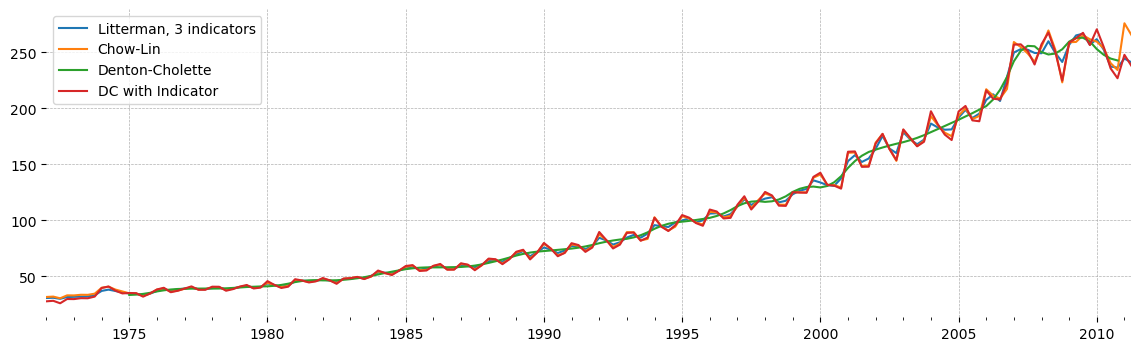

In [14]:
fig, ax = plt.subplots()
sales_q_litterman.plot(ax=ax, label="Litterman, 3 indicators")
sales_q_chow_lin.plot(ax=ax, label="Chow-Lin")
sales_q_dc.plot(ax=ax, label="Denton-Cholette")
sales_q_dc_indicator.plot(ax=ax, label="DC with Indicator")
ax.legend()
plt.show()

# Yearly to Monthly

As noted above, Yearly to Quarterly, Yearly to Monthly, and Monthly to Quarterly are supported. Here we use a monthly indicator to disaggregate to monthly data.

You can silence the regression output table by passing `verbose=False`.

In [15]:
sales_m_litterman = disaggregate_series(
    sales_a,
    exports_m.assign(intercept=1),
    method="litterman",
    agg_func="sum",
    optimizer_kwargs={"method": "nelder-mead"},
    verbose=False,
)

<Axes: >

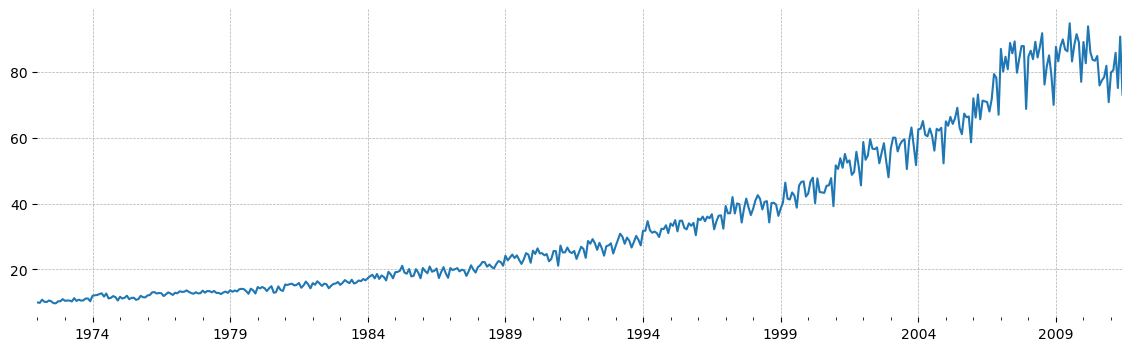

In [16]:
sales_m_litterman.plot()